In [1]:
import transformers

print("Transformers Version:", transformers.__version__)


Transformers Version: 4.26.1


In [2]:
import warnings
from transformers import logging

warnings.filterwarnings('ignore')
logging.set_verbosity_error()


In [3]:
import random, os
import numpy as np
import torch

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)


In [4]:
import datasets
import pandas as pd
from ast import literal_eval
datasets.disable_caching()

data_dir = '/kaggle/input/vispamdataset-v2/preprocessed/'

def load_data(data_dir):
    train_df = pd.read_csv(data_dir + 'train.csv', converters={'categories': literal_eval})
    dev_df = pd.read_csv(data_dir + 'dev.csv', converters={'categories': literal_eval})
    test_df = pd.read_csv(data_dir + 'test.csv', converters={'categories': literal_eval})
    
    train_dataset = datasets.Dataset.from_dict(train_df)
    dev_dataset = datasets.Dataset.from_dict(dev_df)
    test_dataset = datasets.Dataset.from_dict(test_df)
    dataset_dict = datasets.DatasetDict({'train': train_dataset, 'dev': dev_dataset, 'test': test_dataset})
    
    return dataset_dict

vispam_datasets = load_data(data_dir)


In [5]:
categories = set(vispam_datasets['train']['category'] + vispam_datasets['dev']['category'] + vispam_datasets['test']['category'])
category2idx = {p:i for i, p in enumerate(categories)}
num_categories = len(category2idx)
print("Number of categories:", num_categories)


Number of categories: 12


In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

def encode_mapping(examples):
    text_encoded = tokenizer(examples["clean_tokenized_comment"], padding="max_length", max_length=100, truncation=True, add_special_tokens=True)
    category_ids = [category2idx[category] for category in examples['category']]
    text_encoded.update({"category_id": category_ids})
    
    return text_encoded


encoded_datasets = vispam_datasets.map(encode_mapping, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-2])
encoded_datasets.set_format("torch")


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MetaParamManager():
    
    def __init__(self):
        self.meta_em = {}

    def state_dict(self):
        return self.meta_em

    def register(self, name, param):
        self.meta_em[name] = param
        

class BasicLinear(nn.Module):
    
    def __init__(self, state_size, num_classes):
        super(BasicLinear, self).__init__()
        self.W = nn.Linear(state_size, num_classes, bias=False)

    def forward(self, x):
        out = self.W(x)
        return out
    
    
class CustLinear(nn.Module):
    
    def __init__(self, meta_units, state_size, num_classes, meta_param_manager):
        super(CustLinear, self).__init__()
        
        self.state_size = state_size
        self.num_classes = num_classes
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, state_size*num_classes))
            meta_param_manager.register("CustLinear." + name, getattr(self, name).weight)

    def forward(self, x, category_id):
        kwargs = {'category_id': category_id}
        W = torch.cat([getattr(self, name)(idx).view(x.shape[0], self.state_size, self.num_classes) for name, idx in kwargs.items()], dim=1)
        x = x.unsqueeze(dim=1).repeat(1, 1, len(kwargs))
        out = torch.bmm(x, W).squeeze(dim=1)
        return out
    
    
class BasisCustLinear(nn.Module):
    
    def __init__(self, meta_units, meta_dim, key_query_size, state_size, num_bases, num_classes, meta_param_manager):
        super(BasisCustLinear, self).__init__()
        
        self.state_size = state_size
        self.num_classes = num_classes
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, meta_dim))
            meta_param_manager.register("BasisCustLinear." + name, getattr(self, name).weight)

        self.P = nn.Sequential(
            nn.Linear(meta_dim*len(meta_units), key_query_size),  # From MetaData to Query
            nn.Tanh(),
            # Calculate weights of each Basis: Key & Query Inner-product
            nn.Linear(key_query_size, num_bases, bias=False),
            nn.Softmax(dim=1),
            nn.Linear(num_bases, state_size * num_classes),  # Weighted Sum of Bases
        )
        
    def forward(self, x, category_id):
        kwargs = {'category_id': category_id}
        conc = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        W = self.P(conc).view(x.shape[0], self.state_size, self.num_classes)
        out = torch.bmm(x.unsqueeze(dim=1), W).squeeze(dim=1)
        return out
    
    
class BasicBias(nn.Module):
    
    def __init__(self, num_classes):
        super(BasicBias, self).__init__()
        self.b = nn.Parameter(torch.zeros((1, num_classes)))

    def forward(self):
        return self.b
    
    
class CustBias(nn.Module):
    
    def __init__(self, meta_units, state_size, num_classes, meta_param_manager):
        super(CustBias, self).__init__()
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, state_size))
            meta_param_manager.register("CustBias." + name, getattr(self, name).weight)
            
        self.Y = nn.Linear(state_size*len(meta_units), num_classes, bias=False)

    def forward(self, category_id):
        kwargs = {'category_id': category_id}
        conc = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        out = self.Y(conc)
        return out
    
    
class BasisCustBias(nn.Module):
    
    def __init__(self, meta_units, meta_dim, state_size, key_query_size, num_bases, num_classes, meta_param_manager):
        super(BasisCustBias, self).__init__()
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, meta_dim))
            meta_param_manager.register("BasisCustBias." + name, getattr(self, name).weight)

        self.P = nn.Sequential(
            # From MetaData to Query
            nn.Linear(meta_dim*len(meta_units), key_query_size),
            nn.Tanh(),
            # Calculate Weights of each Basis: Key & Query Inner-product
            nn.Linear(key_query_size, num_bases, bias=False),
            nn.Softmax(dim=1),
            # Weighted Sum of Bases
            nn.Linear(num_bases, state_size),
        )
        
        self.Y = nn.Linear(state_size, num_classes, bias=False)

    def forward(self, category_id):
        kwargs = {'category_id': category_id}
        conc = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        out = self.Y(self.P(conc))
        return out


In [8]:
from torch import nn
from transformers import AutoModel, BertModel

class ViSpam_Classifier(nn.Module):
    
    def __init__(self, model_name, task, freeze_bert=False, drop=0.3):
        super(ViSpam_Classifier, self).__init__()
        
        self.model_name = model_name
        name, model_type = model_name.split('_')
        
        assert name in ['PhoBERT', 'BERT4News']
        assert model_type in ['CustBias', 'CustLinear', 'BasisCustBias', 'BasisCustLinear']
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.freeze_bert = freeze_bert
        self.drop = drop
        
        self.meta_dim = 64
        self.key_query_size = 64
        self.num_bases = 4
        
        self.meta_param_manager = MetaParamManager()
        self.meta_units = [('category_id', num_categories)]
        
        if name == 'PhoBERT':
            self.bert = AutoModel.from_pretrained('vinai/phobert-base')
        else:
            self.bert = BertModel.from_pretrained('NlpHUST/vibert4news-base-cased')
            
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
                
        self.state_size = 768
        
        # self.drop = nn.Dropout(drop)
        # self.fc = nn.Linear(self.bert.config.hidden_size, self.state_size)
        # nn.init.normal_(self.fc.weight, std=0.02)
        # nn.init.normal_(self.fc.bias, 0)
        
        # Linear
        if model_type == 'CustLinear':
            self.W = CustLinear(
                meta_units=self.meta_units,
                state_size=self.state_size,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustLinear':
            self.W = BasisCustLinear(
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                key_query_size=self.key_query_size,
                state_size=self.state_size,
                num_bases=self.num_bases,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.W = BasicLinear(state_size=self.state_size, num_classes=self.num_classes)
            
        # Bias
        if model_type == 'CustBias':
            self.bias = CustBias(
                meta_units=self.meta_units,
                state_size=self.state_size,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustBias':
            self.bias = BasisCustBias(
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                state_size=self.state_size,
                key_query_size=self.key_query_size,
                num_bases=self.num_bases,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.bias = BasicBias(self.num_classes)
        
    def forward(self, input_ids, attention_mask, category_id):
        batch_size, sequence_length = input_ids.shape
        last_hidden_state, output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        
        # output = self.drop(bert_output)
        # output = self.fc(output)
        
        if 'CustLinear' in self.model_name:
            x = self.W(output, category_id)
        else:
            x = self.W(output)

        if 'CustBias' in self.model_name:
            x += self.bias(category_id)
        else:
            x += self.bias()

        return x


In [9]:
import torch
import numpy as np

class EarlyStopping:
    
    def __init__(self, patience=5, verbose=True, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        
    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
            
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        

In [10]:
import os
import gc
import json
import torch
from torch import nn
import numpy as np
from scipy import interpolate
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot, plot

def train_step(model, criterion, optimizer, train_dataloader, task):
    model.train()
    losses = []
    correct = 0
    
    trues = []
    predicts = []

    label_column = 'label' if task == 1 else 'spam_label'
    
    for data in tqdm(train_dataloader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        category_id = data['category_id'].to(device)
        labels = data[label_column].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, category_id=category_id)

        loss = criterion(outputs, labels)
        pred = torch.max(outputs, dim=1)[1]
        
        correct += torch.sum(pred == labels)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()
        
        trues.extend(labels.cpu().detach().numpy())
        predicts.extend(pred.cpu().detach().numpy())

    accuracy = correct.double().cpu().data.numpy()/len(train_dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, f1_score(trues, predicts, average='macro'), loss


def validation_step(model, criterion, dataloader, task):
    model.eval()
    losses = []
    correct = 0
    
    trues = []
    predicts = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            category_id = data['category_id'].to(device)
            labels = data[label_column].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, category_id=category_id)
            pred = torch.max(outputs, dim=1)[1]
            
            loss = criterion(outputs, labels)
            correct += torch.sum(pred == labels)
            losses.append(loss.item())
            
            trues.extend(labels.cpu().detach().numpy())
            predicts.extend(pred.cpu().detach().numpy())
            
    accuracy = correct.double().cpu().data.numpy()/len(dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, f1_score(trues, predicts, average='macro'), loss


def train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task):
    torch.cuda.empty_cache()
    gc.collect()
    
    Path(model.model_name).mkdir(parents=True, exist_ok=True)
    
    if early_stopping:
        path_checkpoint = os.path.join(model.model_name, f"{model.model_name}_checkpoint_({task}).pth")
        early_stopping.path = path_checkpoint
    
    best_f1 = 0
    best_model_path = os.path.join(model.model_name, f"{model.model_name}_best_model_({task}).pth")
    last_model_path = os.path.join(model.model_name, f"{model.model_name}_last_model_({task}).pth")
    history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        print("-"*50)
        
        train_accuracy, train_f1, train_loss = train_step(model, criterion, optimizer, train_dataloader, task)
        val_accuracy, val_f1, val_loss = validation_step(model, criterion, val_dataloader, task)
        
        history['train_acc'].append(train_accuracy)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_accuracy)
        history['val_loss'].append(val_loss)
        
        print("Train Accuracy: {:.4f} - Train F1-score: {:.4f} - Train Loss: {:.4f}".format(train_accuracy, train_f1, train_loss))
        print("Valid Accuracy: {:.4f} - Valid F1-score: {:.4f} - Valid Loss: {:.4f}".format(val_accuracy, val_f1, val_loss))
        
        if val_f1 > best_f1:
            torch.save(model.state_dict(), best_model_path)
            best_f1 = val_f1
        
        if epoch + 1 == epochs:
            torch.save(model.state_dict(), last_model_path)
            
        if early_stopping:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                torch.save(model.state_dict(), last_model_path)
                print("Early stopping.")
                break
    
    history_path = os.path.join(model.model_name, f"{model.model_name}_history_({task}).json")
    with open(history_path, 'w') as f:
        json.dump(history, f)
        
    # with open(history_path) as f:
    #     history = json.load(f)
    
    return history


def test(model, dataloader, task):
    model.eval()
    predicts = []
    predict_probs = []
    true_labels = []
    
    label_column = 'label' if task == 1 else 'spam_label'

    for data in tqdm(dataloader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        category_id = data['category_id'].to(device)
        labels = data[label_column].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, category_id=category_id)
            
        pred = torch.max(outputs, dim=1)[1]
        predicts.extend(pred.cpu().data.numpy())
        predict_probs.extend(outputs.cpu().data.numpy())
        true_labels.extend(labels.cpu().data.numpy())
        
    return true_labels, predicts


def evaluate(true_labels, predicts):
    test_accuracy = accuracy_score(true_labels, predicts)
    test_precision = precision_score(true_labels, predicts, average='macro')
    test_recall = recall_score(true_labels, predicts, average='macro')
    test_f1 = f1_score(true_labels, predicts, average='macro')
    test_cm = confusion_matrix(true_labels, predicts)
    
    print("Accuracy: {:.4f}".format(test_accuracy))
    print("Precision: {:.4f}".format(test_precision))
    print("Recall: {:.4f}".format(test_recall))
    print("F1-score: {:.4f}".format(test_f1))
    print("Confusion matrix:\n", test_cm)
    print(classification_report(true_labels, predicts, digits=4))
    
    return test_cm


def save_visualization_history(history, model_name, task):
    if len(history['train_loss']) <= 1:
        return False
    
    colors = plt.get_cmap('tab10').colors

    epochs = np.arange(1, len(history['train_loss']) + 1)
    xnew = np.linspace(epochs[0], epochs[-1], 300)
    
    train_loss_smooth = interpolate.interp1d(epochs, history['train_loss'], kind='linear')(xnew)
    val_loss_smooth = interpolate.interp1d(epochs, history['val_loss'], kind='linear')(xnew)

    fig, ax = plt.subplots()
    ax.plot(xnew, train_loss_smooth, color=colors[0], linewidth=3, label='Training Loss')
    ax.plot(xnew, val_loss_smooth, color=colors[1], linewidth=3, label='Validation Loss')
    ax.set_title('Training and Validation Loss', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10, labelpad=10)
    ax.set_ylabel('Loss', fontsize=10, labelpad=10)
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis='y')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size': 10})
    
    file_name = os.path.join(model_name, f"{model_name}_loss_visualization_({task}).png")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    train_acc_smooth = interpolate.interp1d(epochs, history['train_acc'], kind='linear')(xnew)
    val_acc_smooth = interpolate.interp1d(epochs, history['val_acc'], kind='linear')(xnew)

    fig, ax = plt.subplots()
    ax.plot(xnew, train_acc_smooth, color=colors[2], linewidth=3, label='Training Accuracy')
    ax.plot(xnew, val_acc_smooth, color=colors[4], linewidth=3, label='Validation Accuracy')
    ax.set_title('Training and Validation Accuracy', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10, labelpad=10)
    ax.set_ylabel('Accuracy', fontsize=10, labelpad=10)
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis='y')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size': 10})
    
    file_name = os.path.join(model_name, f"{model_name}_accuracy_visualization_({task}).png")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close(fig)


def plotting_history(history):
    assert len(history['train_loss']) == len(history['val_loss'])
    assert len(history['train_acc']) == len(history['val_acc'])
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Accuracy"), shared_yaxes=False, shared_xaxes=False, vertical_spacing=0.1, horizontal_spacing=0.05)
    
    num_epochs = len(history['train_loss'])
    epoch_labels = list(range(1, num_epochs+1))

    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_loss'], name='train_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_loss'], name='val_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_acc'], name='train_accuracy', legendgroup='2'), row=1, col=2)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_acc'], name='val_accuracy', legendgroup='2'), row=1, col=2)

    fig.update_layout(legend=dict(orientation="h", xanchor="center", x=0.5), showlegend=True)
    fig.show()
    
    
def plotting_confusion_matrix(confusion_matrix, task):
    if task == 1:
        labels = ['no-spam', 'spam']
        font_size = 30
    else:
        labels = ['no-spam', 'spam-1', 'spam-2', 'spam-3']
        font_size = 22
        
    plt.figure(dpi=100)
    df_cm = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    sns.heatmap(df_cm, annot=True, cmap="Greys", fmt="g", cbar=True, annot_kws={"size": font_size})
    plt.show()


In [11]:
import torch
import numpy as np
from sklearn.utils import class_weight

labels = vispam_datasets['train']['label']
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

spam_labels = vispam_datasets['train']['spam_label']
spam_class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(spam_labels), y=spam_labels)
spam_class_weights = torch.tensor(spam_class_weights, dtype=torch.float)

class_weights, spam_class_weights


(tensor([0.6797, 1.8909]), tensor([ 0.3399, 16.9242,  3.2375,  1.4499]))

In [12]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=16)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=16)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=16)


# PhoBERT - Cust Bias

## Task 1

In [14]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="PhoBERT_CustBias", task=1).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=1)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8344 - Train F1-score: 0.7952 - Train Loss: 0.4102
Valid Accuracy: 0.8773 - Valid F1-score: 0.8406 - Valid Loss: 0.3579
Validation loss decreased (inf --> 0.357887). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8915 - Train F1-score: 0.8632 - Train Loss: 0.3097
Valid Accuracy: 0.8924 - Valid F1-score: 0.8571 - Valid Loss: 0.3765
EarlyStopping counter: 1 out of 3
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9188 - Train F1-score: 0.8970 - Train Loss: 0.2597
Valid Accuracy: 0.8754 - Valid F1-score: 0.8422 - Valid Loss: 0.3995
EarlyStopping counter: 2 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9429 - Train F1-score: 0.9269 - Train Loss: 0.2163
Valid Accuracy: 0.8918 - Valid F1-score: 0.8575 - Valid Loss: 0.4516
EarlyStopping counter: 3 out of 3
Early stopping.


In [15]:
save_visualization_history(history, 'PhoBERT_CustBias', task=1)
plotting_history(history)


In [16]:
import os
import torch

model_name = "PhoBERT_CustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8935
Precision: 0.8639
Recall: 0.8626
F1-score: 0.8632
Confusion matrix:
 [[2703  208]
 [ 214  838]]
              precision    recall  f1-score   support

           0     0.9266    0.9285    0.9276      2911
           1     0.8011    0.7966    0.7989      1052

    accuracy                         0.8935      3963
   macro avg     0.8639    0.8626    0.8632      3963
weighted avg     0.8933    0.8935    0.8934      3963



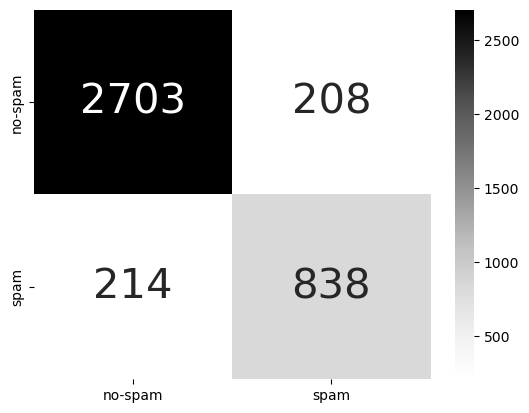

In [17]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [18]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="PhoBERT_CustBias", task=2).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=2)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.7454 - Train F1-score: 0.5852 - Train Loss: 0.8148
Valid Accuracy: 0.8634 - Valid F1-score: 0.6866 - Valid Loss: 0.7759
Validation loss decreased (inf --> 0.775872). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8605 - Train F1-score: 0.7201 - Train Loss: 0.5747
Valid Accuracy: 0.8691 - Valid F1-score: 0.6510 - Valid Loss: 0.7869
EarlyStopping counter: 1 out of 3
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9003 - Train F1-score: 0.7886 - Train Loss: 0.4504
Valid Accuracy: 0.8332 - Valid F1-score: 0.6193 - Valid Loss: 0.7885
EarlyStopping counter: 2 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9275 - Train F1-score: 0.8425 - Train Loss: 0.3606
Valid Accuracy: 0.8949 - Valid F1-score: 0.6739 - Valid Loss: 1.2517
EarlyStopping counter: 3 out of 3
Early stopping.


In [19]:
save_visualization_history(history, 'PhoBERT_CustBias', task=2)
plotting_history(history)


In [20]:
import os
import torch

model_name = "PhoBERT_CustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8854
Precision: 0.7385
Recall: 0.6882
F1-score: 0.7107
Confusion matrix:
 [[2757   18   84   52]
 [  15   27    2   10]
 [ 156    0  142   11]
 [  90    3   13  583]]
              precision    recall  f1-score   support

           0     0.9135    0.9471    0.9300      2911
           1     0.5625    0.5000    0.5294        54
           2     0.5892    0.4595    0.5164       309
           3     0.8887    0.8462    0.8669       689

    accuracy                         0.8854      3963
   macro avg     0.7385    0.6882    0.7107      3963
weighted avg     0.8791    0.8854    0.8813      3963



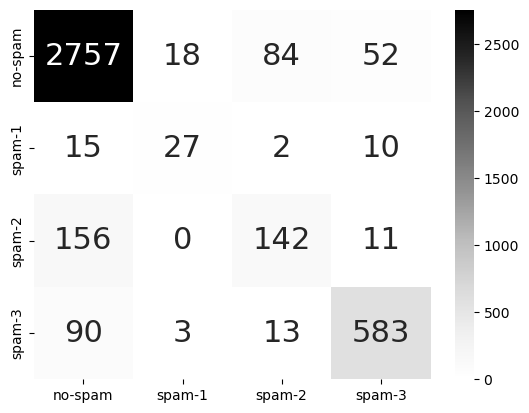

In [21]:
plotting_confusion_matrix(test_cm, task=2)


# PhoBERT - Basis Cust Bias

## Task 1

In [22]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="PhoBERT_BasisCustBias", task=1).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=1)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8392 - Train F1-score: 0.8006 - Train Loss: 0.4006
Valid Accuracy: 0.8785 - Valid F1-score: 0.8350 - Valid Loss: 0.4266
Validation loss decreased (inf --> 0.426632). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8930 - Train F1-score: 0.8652 - Train Loss: 0.3063
Valid Accuracy: 0.8836 - Valid F1-score: 0.8422 - Valid Loss: 0.3997
Validation loss decreased (0.426632 --> 0.399727). Saving model ...
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9219 - Train F1-score: 0.9006 - Train Loss: 0.2538
Valid Accuracy: 0.9031 - Valid F1-score: 0.8659 - Valid Loss: 0.3849
Validation loss decreased (0.399727 --> 0.384899). Saving model ...
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9401 - Train F1-score: 0.9236 - Train Loss: 0.2184
Valid Accuracy: 0.8924 - Valid F1-score: 0.8531 - Valid Loss: 0.5934
EarlyStopping counter: 1 out of 3
Epoch 5/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9572 - Train F1-score: 0.9449 - Train Loss: 0.1794
Valid Accuracy: 0.8880 - Valid F1-score: 0.8523 - Valid Loss: 0.5798
EarlyStopping counter: 2 out of 3
Epoch 6/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9685 - Train F1-score: 0.9595 - Train Loss: 0.1422
Valid Accuracy: 0.8892 - Valid F1-score: 0.8569 - Valid Loss: 0.5591
EarlyStopping counter: 3 out of 3
Early stopping.


In [23]:
save_visualization_history(history, 'PhoBERT_BasisCustBias', task=1)
plotting_history(history)


In [24]:
import os
import torch

model_name = "PhoBERT_BasisCustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8870
Precision: 0.8531
Recall: 0.8602
F1-score: 0.8565
Confusion matrix:
 [[2670  241]
 [ 207  845]]
              precision    recall  f1-score   support

           0     0.9281    0.9172    0.9226      2911
           1     0.7781    0.8032    0.7905      1052

    accuracy                         0.8870      3963
   macro avg     0.8531    0.8602    0.8565      3963
weighted avg     0.8882    0.8870    0.8875      3963



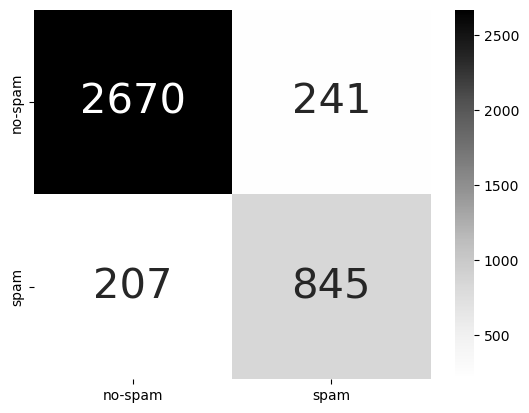

In [25]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [26]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="PhoBERT_BasisCustBias", task=2).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=2)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.7634 - Train F1-score: 0.5988 - Train Loss: 0.7822
Valid Accuracy: 0.8357 - Valid F1-score: 0.6318 - Valid Loss: 0.6880
Validation loss decreased (inf --> 0.687975). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8611 - Train F1-score: 0.7172 - Train Loss: 0.5555
Valid Accuracy: 0.8691 - Valid F1-score: 0.7061 - Valid Loss: 0.7848
EarlyStopping counter: 1 out of 3
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8994 - Train F1-score: 0.7919 - Train Loss: 0.4549
Valid Accuracy: 0.8383 - Valid F1-score: 0.6714 - Valid Loss: 0.7742
EarlyStopping counter: 2 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9249 - Train F1-score: 0.8377 - Train Loss: 0.3775
Valid Accuracy: 0.8848 - Valid F1-score: 0.6918 - Valid Loss: 1.0082
EarlyStopping counter: 3 out of 3
Early stopping.


In [27]:
save_visualization_history(history, 'PhoBERT_BasisCustBias', task=2)
plotting_history(history)


In [28]:
import os
import torch

model_name = "PhoBERT_BasisCustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8761
Precision: 0.7369
Recall: 0.7171
F1-score: 0.7219
Confusion matrix:
 [[2674   10  175   52]
 [  17   26    2    9]
 [ 107    0  195    7]
 [  81    5   26  577]]
              precision    recall  f1-score   support

           0     0.9288    0.9186    0.9237      2911
           1     0.6341    0.4815    0.5474        54
           2     0.4899    0.6311    0.5516       309
           3     0.8946    0.8374    0.8651       689

    accuracy                         0.8761      3963
   macro avg     0.7369    0.7171    0.7219      3963
weighted avg     0.8846    0.8761    0.8793      3963



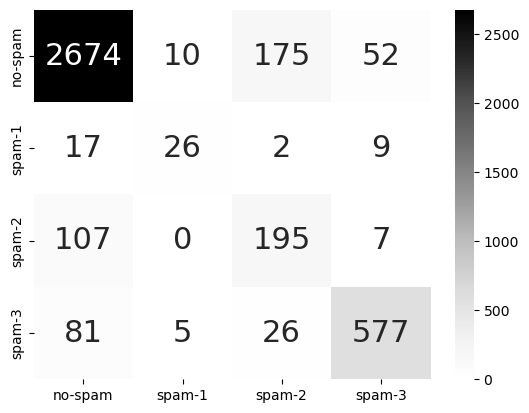

In [29]:
plotting_confusion_matrix(test_cm, task=2)


# PhoBERT - Cust Linear

## Task 1

In [30]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="PhoBERT_CustLinear", task=1).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=1)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.6969 - Train F1-score: 0.6505 - Train Loss: 1.4241
Valid Accuracy: 0.8326 - Valid F1-score: 0.7828 - Valid Loss: 0.8416
Validation loss decreased (inf --> 0.841638). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8163 - Train F1-score: 0.7769 - Train Loss: 0.7520
Valid Accuracy: 0.8521 - Valid F1-score: 0.8085 - Valid Loss: 0.7150
Validation loss decreased (0.841638 --> 0.715044). Saving model ...
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8639 - Train F1-score: 0.8310 - Train Loss: 0.5863
Valid Accuracy: 0.8647 - Valid F1-score: 0.8162 - Valid Loss: 0.8275
EarlyStopping counter: 1 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8979 - Train F1-score: 0.8712 - Train Loss: 0.4546
Valid Accuracy: 0.8672 - Valid F1-score: 0.8361 - Valid Loss: 0.6084
Validation loss decreased (0.715044 --> 0.608393). Saving model ...
Epoch 5/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9226 - Train F1-score: 0.9019 - Train Loss: 0.3800
Valid Accuracy: 0.8855 - Valid F1-score: 0.8412 - Valid Loss: 1.1610
EarlyStopping counter: 1 out of 3
Epoch 6/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9450 - Train F1-score: 0.9296 - Train Loss: 0.3071
Valid Accuracy: 0.8861 - Valid F1-score: 0.8511 - Valid Loss: 1.0497
EarlyStopping counter: 2 out of 3
Epoch 7/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9621 - Train F1-score: 0.9514 - Train Loss: 0.2155
Valid Accuracy: 0.8880 - Valid F1-score: 0.8464 - Valid Loss: 1.5070
EarlyStopping counter: 3 out of 3
Early stopping.


In [31]:
save_visualization_history(history, 'PhoBERT_CustLinear', task=1)
plotting_history(history)


In [32]:
import os
import torch

model_name = "PhoBERT_CustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8890
Precision: 0.8673
Recall: 0.8403
F1-score: 0.8524
Confusion matrix:
 [[2748  163]
 [ 277  775]]
              precision    recall  f1-score   support

           0     0.9084    0.9440    0.9259      2911
           1     0.8262    0.7367    0.7789      1052

    accuracy                         0.8890      3963
   macro avg     0.8673    0.8403    0.8524      3963
weighted avg     0.8866    0.8890    0.8869      3963



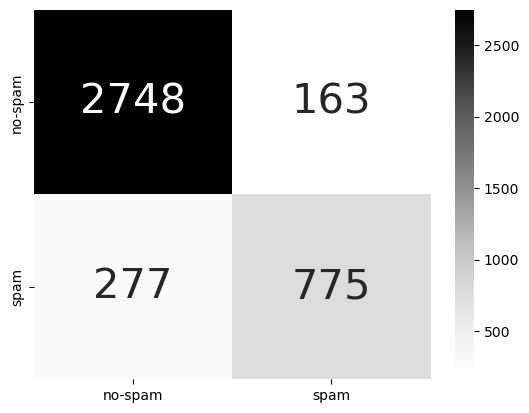

In [33]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [34]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="PhoBERT_CustLinear", task=2).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=2)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.5856 - Train F1-score: 0.3948 - Train Loss: 2.7508
Valid Accuracy: 0.8383 - Valid F1-score: 0.5447 - Valid Loss: 2.1184
Validation loss decreased (inf --> 2.118375). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.7487 - Train F1-score: 0.5641 - Train Loss: 1.3819
Valid Accuracy: 0.8250 - Valid F1-score: 0.5727 - Valid Loss: 1.6109
Validation loss decreased (2.118375 --> 1.610903). Saving model ...
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8147 - Train F1-score: 0.6505 - Train Loss: 1.0914
Valid Accuracy: 0.8446 - Valid F1-score: 0.6536 - Valid Loss: 1.5728
Validation loss decreased (1.610903 --> 1.572778). Saving model ...
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8643 - Train F1-score: 0.7237 - Train Loss: 0.8712
Valid Accuracy: 0.8609 - Valid F1-score: 0.6586 - Valid Loss: 1.5918
EarlyStopping counter: 1 out of 3
Epoch 5/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8953 - Train F1-score: 0.7763 - Train Loss: 0.6891
Valid Accuracy: 0.8666 - Valid F1-score: 0.6441 - Valid Loss: 2.0412
EarlyStopping counter: 2 out of 3
Epoch 6/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9189 - Train F1-score: 0.8222 - Train Loss: 0.5677
Valid Accuracy: 0.8697 - Valid F1-score: 0.6457 - Valid Loss: 2.1746
EarlyStopping counter: 3 out of 3
Early stopping.


In [35]:
save_visualization_history(history, 'PhoBERT_CustLinear', task=2)
plotting_history(history)


In [36]:
import os
import torch

model_name = "PhoBERT_CustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8748
Precision: 0.6996
Recall: 0.7021
F1-score: 0.6993
Confusion matrix:
 [[2701   13  153   44]
 [  19   26    3    6]
 [ 117    2  182    8]
 [  95   15   21  558]]
              precision    recall  f1-score   support

           0     0.9212    0.9279    0.9245      2911
           1     0.4643    0.4815    0.4727        54
           2     0.5070    0.5890    0.5449       309
           3     0.9058    0.8099    0.8552       689

    accuracy                         0.8748      3963
   macro avg     0.6996    0.7021    0.6993      3963
weighted avg     0.8800    0.8748    0.8767      3963



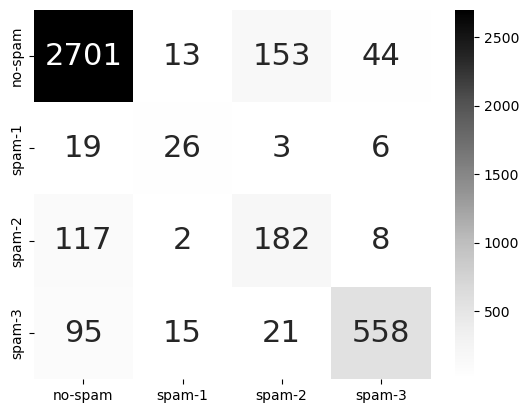

In [37]:
plotting_confusion_matrix(test_cm, task=2)


# PhoBERT Basis Cust Linear

## Task 1

In [38]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="PhoBERT_BasisCustLinear", task=1).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=1)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.7935 - Train F1-score: 0.7526 - Train Loss: 0.5287
Valid Accuracy: 0.8817 - Valid F1-score: 0.8210 - Valid Loss: 0.7166
Validation loss decreased (inf --> 0.716633). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8648 - Train F1-score: 0.8325 - Train Loss: 0.3741
Valid Accuracy: 0.8886 - Valid F1-score: 0.8384 - Valid Loss: 0.4972
Validation loss decreased (0.716633 --> 0.497157). Saving model ...
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9039 - Train F1-score: 0.8793 - Train Loss: 0.3041
Valid Accuracy: 0.9025 - Valid F1-score: 0.8651 - Valid Loss: 0.4590
Validation loss decreased (0.497157 --> 0.458997). Saving model ...
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9280 - Train F1-score: 0.9087 - Train Loss: 0.2441
Valid Accuracy: 0.8930 - Valid F1-score: 0.8578 - Valid Loss: 0.5191
EarlyStopping counter: 1 out of 3
Epoch 5/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9501 - Train F1-score: 0.9361 - Train Loss: 0.2207
Valid Accuracy: 0.8829 - Valid F1-score: 0.8506 - Valid Loss: 0.6129
EarlyStopping counter: 2 out of 3
Epoch 6/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9656 - Train F1-score: 0.9558 - Train Loss: 0.1604
Valid Accuracy: 0.8861 - Valid F1-score: 0.8550 - Valid Loss: 0.8073
EarlyStopping counter: 3 out of 3
Early stopping.


In [39]:
save_visualization_history(history, 'PhoBERT_BasisCustLinear', task=1)
plotting_history(history)


In [40]:
import os
import torch

model_name = "PhoBERT_BasisCustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8852
Precision: 0.8482
Recall: 0.8672
F1-score: 0.8568
Confusion matrix:
 [[2636  275]
 [ 180  872]]
              precision    recall  f1-score   support

           0     0.9361    0.9055    0.9206      2911
           1     0.7602    0.8289    0.7931      1052

    accuracy                         0.8852      3963
   macro avg     0.8482    0.8672    0.8568      3963
weighted avg     0.8894    0.8852    0.8867      3963



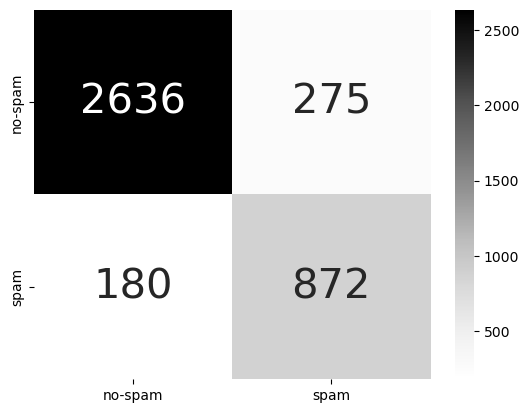

In [41]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [42]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="PhoBERT_BasisCustLinear", task=2).to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
epochs = 20
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task=2)


Epoch 1/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.6969 - Train F1-score: 0.5259 - Train Loss: 1.0003
Valid Accuracy: 0.7332 - Valid F1-score: 0.5992 - Valid Loss: 0.8776
Validation loss decreased (inf --> 0.877614). Saving model ...
Epoch 2/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8164 - Train F1-score: 0.6674 - Train Loss: 0.6955
Valid Accuracy: 0.8414 - Valid F1-score: 0.6333 - Valid Loss: 0.8018
Validation loss decreased (0.877614 --> 0.801789). Saving model ...
Epoch 3/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8652 - Train F1-score: 0.7346 - Train Loss: 0.5364
Valid Accuracy: 0.8817 - Valid F1-score: 0.6486 - Valid Loss: 1.3762
EarlyStopping counter: 1 out of 3
Epoch 4/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9056 - Train F1-score: 0.8038 - Train Loss: 0.4276
Valid Accuracy: 0.8735 - Valid F1-score: 0.6646 - Valid Loss: 1.3786
EarlyStopping counter: 2 out of 3
Epoch 5/20
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9337 - Train F1-score: 0.8617 - Train Loss: 0.3234
Valid Accuracy: 0.8811 - Valid F1-score: 0.6474 - Valid Loss: 1.7678
EarlyStopping counter: 3 out of 3
Early stopping.


In [43]:
save_visualization_history(history, 'PhoBERT_BasisCustLinear', task=2)
plotting_history(history)


In [44]:
import os
import torch

model_name = "PhoBERT_BasisCustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8764
Precision: 0.6997
Recall: 0.7030
F1-score: 0.7012
Confusion matrix:
 [[2682   21  125   83]
 [  15   27    2   10]
 [ 133    3  158   15]
 [  68    4   11  606]]
              precision    recall  f1-score   support

           0     0.9255    0.9213    0.9234      2911
           1     0.4909    0.5000    0.4954        54
           2     0.5338    0.5113    0.5223       309
           3     0.8487    0.8795    0.8639       689

    accuracy                         0.8764      3963
   macro avg     0.6997    0.7030    0.7012      3963
weighted avg     0.8757    0.8764    0.8759      3963



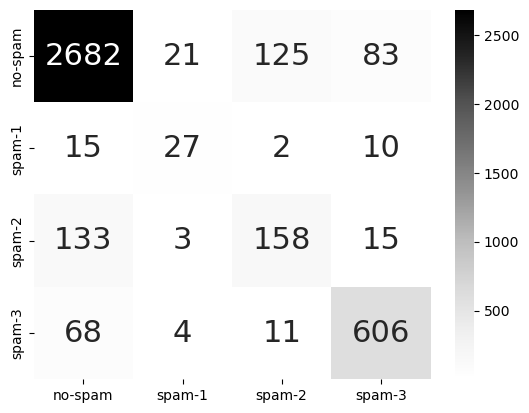

In [45]:
plotting_confusion_matrix(test_cm, task=2)
